In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from functions_SqRA import grid1, adjancency_matrix_sparse, build_sqra, build_sqra_i
from pcca import pcca


np.random.seed(0) 

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu mol-1
gamma  = 1                           # ps-1 
D      = kB * T / mass / gamma       # nm2 ps-1
sigma  = np.sqrt(2 * D)              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

## Potential energy function

In [3]:
def V_i(x):
    return 1*(x**2 - 1) ** 2 

def V_ij(x,y):
    return 0.5*np.abs(x - y)**2

def V_I(N,X):
    
    v = 0
    
    for i in range(N-1):
        v = v + V_ij(X[i],X[i+1])
    return v

def V(N, c, X):
    
    v = 0
    
    for i in range(N):
        v = v + V_i(X[i])
        
        if i<N-1:
            v = v + c * V_ij(X[i],X[i+1])
            
    return v

## Grid definition

In [4]:
# Number of springs
Nd       = 3

Nedges = 6

a = 2.5
xcenters, xedges, xbins, dx = grid1(-a, a, Nedges)

bins = np.array([xbins for i in range(Nd)])
DX   = np.array([dx    for i in range(Nd)])

grid = np.meshgrid(*[xcenters for i in range(Nd)])
X    = np.stack([grid[i] for i in range(Nd)])

# Total number of bins
Nbins = xbins ** Nd
print("Total number of bins: ", Nbins)

Total number of bins:  125


## Unperturbed system
#### Build matrix of each subsystem

In [5]:
# Stationary distribution
pi_i = np.exp(- beta * V_i(xcenters) ) 
PI = np.array([pi_i for i in range(Nd)]) #, dtype=object 

## SqRA
Q_i, Qo_i =  build_sqra_i(D, PI, DX, bins)

# Eigenvalue problem
evals_i = np.empty(Nd, dtype=object)

for i in range(Nd):
    evals_i[i],   _  =  scipy.sparse.linalg.eigs(Q_i[i],  3, which='LR')
    evals_i[i] = -np.sort(-evals_i[i])

#### Build matrix of full system

In [6]:
# Coupling coefficient
c = 0

# Stationary distribution
pi0 = np.exp(- beta * V(Nd, c, X).flatten('C') )

## SqRA
Q, Qo = build_sqra(D, pi0, DX, bins)

# Eigenvalue problem
evals_c0,    _    = scipy.sparse.linalg.eigs(Q, 6, which='LR')
evals_c0 = -np.sort(-evals_c0)

## Perturbed system

In [7]:
# Coupling coefficient
c = 1

# Stationary distribution
pi_c1 = np.exp(- beta * V(Nd, c, X).flatten('C') )

## SqRA
tildeQ, Qo_c1 = build_sqra(D, pi_c1, DX, bins)

# Eigenvalue problem
evals_c1,    _    = scipy.sparse.linalg.eigs(tildeQ, 6, which='LR')
evals_c1 = -np.sort(-evals_c1)

## PCCA+

In [8]:
# Rate of individual systems
Qc_i  = np.empty(Nd, dtype=object)
chi_i = np.empty(Nd, dtype=object)

for i in range(Nd):
    chi_i, _, _, schurevecs1 = pcca(Q_i[i].toarray(), 2, massmatrix=None)
    Qc_i[i] = np.linalg.pinv(chi_i).dot(Q_i[i].toarray().dot(chi_i))
    print(Qc_i[i])
    
# Uncouled system
chi, e, S, tildeSchurevecs = pcca(Q, 2**Nd, massmatrix=None)
Qc = np.linalg.pinv(chi).dot(Q.dot(chi))

print(" ")
print(Qc)

# Perturbed system
tildeChi, tildee, tildeS, tildeSchurevecs = pcca(tildeQ, 2**Nd, massmatrix=None)
tildeQc = np.linalg.pinv(tildeChi).dot(tildeQ.dot(tildeChi))

print(" ")
print(tildeQc)

[[-0.989777  0.989777]
 [ 0.989777 -0.989777]]
[[-0.989777  0.989777]
 [ 0.989777 -0.989777]]
[[-0.989777  0.989777]
 [ 0.989777 -0.989777]]
Optimization terminated successfully.
         Current function value: -492.629847
         Iterations: 1248
         Function evaluations: 2064
 
[[-2.96933101e+00  9.89777003e-01  1.26425221e-15  9.89777003e-01
  -9.72145976e-15  9.89777003e-01 -1.47809092e-14 -2.71495142e-15]
 [ 9.89777003e-01 -2.96933101e+00  9.89777003e-01 -1.29168036e-15
   9.89777003e-01 -6.03948278e-15  8.86305440e-15 -1.13099422e-14]
 [ 4.07302861e-15  9.89777003e-01 -2.96933101e+00  9.89777003e-01
  -7.55479600e-15  1.11103173e-14 -1.20349870e-14  9.89777003e-01]
 [ 9.89777003e-01 -1.53814073e-14  9.89777003e-01 -2.96933101e+00
   2.51445037e-15 -2.49579094e-15  9.89777003e-01  8.18928549e-15]
 [-2.30211226e-15  9.89777003e-01 -3.70984817e-15 -8.40163314e-15
  -2.96933101e+00  9.89777003e-01 -8.44993042e-15  9.89777003e-01]
 [ 9.89777003e-01 -7.89360680e-16 -1.82801957e-

/home/numerik/ldonati/Nextcloud2/Dokumente/Projects/Decompositional_methods/springs_1d/PRE/optimization.py:37: RuntimeWarning: Maximum number of iterations has been exceeded.
  x = fmin(objective, x0=x, args=(X, A), maxiter=maxiter)


## Discretized Koopman operator

In [9]:
# Calculate approximated Qc
KTAU = np.array([0.1,1,2,5, 10, 15])*0.1


rates = np.zeros((2**Nd,2**Nd,len(KTAU)))

for k,t in enumerate(KTAU):
    
    # Use the full matrix  
    
    
    tildeK = scipy.linalg.expm(tildeQ * t)
    #tildeK = tildeQ * t + np.diag(np.ones(Nbins))
    chi1  = np.matmul(tildeK, chi)
    M     = np.linalg.lstsq(chi1, chi, rcond=-1)[0]
    hatQc = scipy.linalg.logm(np.linalg.inv(M)) / t
    rates[:,:,k] = hatQc

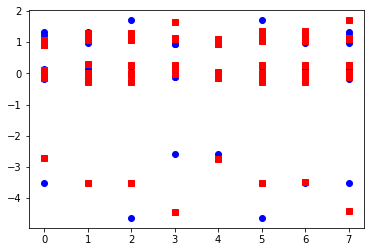

In [10]:
plt.plot(rates[:,:,-1],'bo')
plt.plot(tildeQc,'rs')

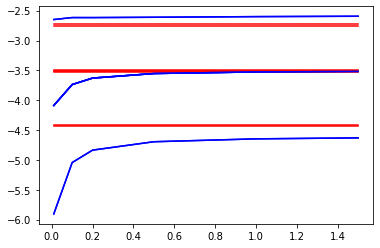

In [21]:
a = 6
b = 6


for i in range(8):
    plt.plot(KTAU, rates[i,i,:], 'b')
    plt.plot([KTAU[0], KTAU[-1]], [tildeQc[i,i], tildeQc[i,i]], 'r')
#plt.ylim(-2,2)

In [12]:
sqra_I = np.exp( - beta * V_I(Nd, X) / 2).reshape(bins)
  
def Q_matmul(v):
    
    #vec = x * sqra_I
    v = v.reshape(bins)
    ui = np.empty(Nd, dtype=object)
    
    for i in range(Nd):
        axes = [[1], [i]]
        td   = np.tensordot(Qo_i[i].toarray(), v, axes=axes)
    
        for j in range(i):
            td = td.swapaxes(j,j+1)

        ui[i] = td
    
    return np.sum(ui)

def tildeQ_matmul(v):
    e     = np.ones(bins)
    v     = np.reshape(v, bins)
    term1 = sqra_I ** -1 * Q_matmul( sqra_I * v )  
    term2 = sqra_I ** -1 * Q_matmul( sqra_I * e ) * v
    out  = term1 - term2
    
    return out.flatten('C')

In [14]:
import scipy.sparse.linalg as spl

# Create the LinearOperator
linear_operator = spl.LinearOperator((Nbins, Nbins), matvec=tildeQ_matmul)


scipy.sparse.linalg.expm_multiply(linear_operator, chi[:,0])

/tmp/ipykernel_889575/2383901055.py:7: UserWarning: Trace of LinearOperator not available, it will be estimated. Provide `traceA` to ensure performance.
  scipy.sparse.linalg.expm_multiply(linear_operator, chi[:,0])


TypeError: 'NoneType' object is not callable

In [28]:
linear_operator.matvec(chi[:,0])

array([ 6.29856405e-15,  6.46569170e-02,  6.04732616e-01,  1.38137048e+00,
        1.80594886e+00, -1.91969923e-14,  7.38468158e-02,  6.90685238e-01,
        1.57770917e+00,  2.06263427e+00, -1.00310817e-14,  4.82721960e-02,
        4.51487215e-01,  1.03131713e+00,  1.34830303e+00, -2.88097136e-15,
        7.70656268e-03,  7.20790601e-02,  1.64647785e-01,  2.15253970e-01,
       -2.34902473e-14, -4.47563784e-14,  8.20472237e-14, -2.33981529e-14,
        1.38947325e-14,  7.14731639e-02,  8.32453951e-02,  2.84748263e-01,
        6.68498496e-01,  8.91330525e-01,  6.68041987e-02,  8.72002255e-02,
        3.51307924e-01,  8.14642942e-01,  1.07648745e+00,  3.57365819e-02,
        5.58828183e-02,  2.67381490e-01,  6.04462484e-01,  7.82788283e-01,
        4.66896524e-03,  1.29308596e-02,  7.94325075e-02,  1.65389149e-01,
        1.98964822e-01,  1.29848047e-14,  6.97160383e-03,  5.33611365e-02,
        9.97506692e-02,  1.06722273e-01,  6.68484601e-01,  3.46402558e-01,
       -7.80655519e-01, -

In [ ]:
# Calculate approximated Qc

Niters = 10
tau =  1

rates = np.zeros((2**Nd,2**Nd,len(KTAU)))


for k,t in enumerate(KTAU):
    
for i in range(Niters):
   
    
    tildeK = scipy.linalg.expm(tildeQ * t)
    #tildeK = tildeQ * t + np.diag(np.ones(Nbins))
    chi1  = np.matmul(tildeK, chi)
    M     = np.linalg.lstsq(chi1, chi, rcond=-1)[0]
    hatQc = scipy.linalg.logm(np.linalg.inv(M)) / t
    rates[:,:,k] = hatQc

In [29]:
scipy.__version__

'1.11.1'